## Plotting Hong Kong locations

Color districts of Hong Kong by Sex Ratio

In [153]:
import operator as op
import json
import urllib.request
import pandas as pd
import folium
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from collections import defaultdict
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# read sex-ratio data in Hong Kong
df = pd.read_csv('hk_sexratio.csv')

# import GeoJSON from internet
dist_geo = 'https://opendata.arcgis.com/datasets/eea8ff2f12b145f7b33c4eef4f045513_0.geojson'

In [87]:
df.iloc[0]['District'] = 'CENTRAL AND WESTERN'

In [98]:
df.set_index('District',inplace=True)
df

,Sex Ratio
District,
CENTRAL AND WESTERN,0.937
EASTERN,0.899
ISLANDS,0.885
KOWLOON CITY,0.923
KWAI TSING,0.919
KWUN TONG,0.913
NORTH,0.937
SAI KUNG,0.912
SHA TIN,0.909


In [111]:
df.iloc[0]['Sex Ratio']

0.937

In [124]:
s = np.linspace(df['Sex Ratio'].min(),df['Sex Ratio'].max(),18)

In [129]:
# Function to map the colors as a function of scaled populations
def pltcolor(l,s):
    stop = 0
    ss = [0]+list(s)+[1]
    i=1
    while stop==0:
        if l >= ss[i-1] and l < ss[i]:
            c = i-1
            stop = 1
        else:
            i = i+1
            if i == len(ss):
                stop = 1
    return c

In [130]:
pltcolor(df.iloc[1]['Sex Ratio'],s)

5

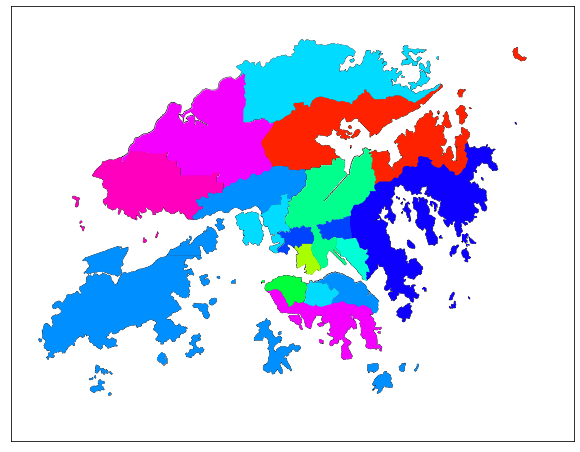

In [133]:
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)
m = Basemap(llcrnrlon=113.8,llcrnrlat=22.1,urcrnrlon=114.5,urcrnrlat=22.6,
            resolution='i', projection='merc')
m.readshapefile('HKG_adm/HKG_adm1', 'hkmap')

dist_dict = set([m.hkmap_info[j]['NAME_1'] for j in np.arange(len(m.hkmap_info))])
dist_color_dict = {}
i = 0
for name in dist_dict:
    dist_color_dict[name] = i
    i += 1

patches = defaultdict(list)
for col in list(dist_color_dict.values()):
    patches[col] = []

for info, shape in zip(m.hkmap_info, m.hkmap):
    try:
        color = dist_color_dict[info['NAME_1']]
        patches[color].append(Polygon(np.array(shape), True))
    except Exception as e:
        pass

cm = plt.get_cmap('gist_rainbow')
cccol = [cm(1.*pltcolor(df.iloc[i]['Sex Ratio'],s)/18) for i in range(18)]
for color in patches:
    p = PatchCollection(patches[color], facecolors=cccol[color], 
                        edgecolors=(0,0,0,0),
                        linewidths=0.0, zorder=2)
    ax.add_collection(p)  

plt.show()

Identifying locations of Kindergartens in Hong Kong colored by types of schools

In [134]:
sch_geo = 'https://opendata.arcgis.com/datasets/3c4bc72e6cf54cfcb658c4de1cc219e1_0.geojson'
webURL = urllib.request.urlopen(sch_geo)
dataurl = webURL.read()
encoding = webURL.info().get_content_charset('utf-8')
sch_data = json.loads(dataurl.decode(encoding))

In [146]:
kindergarten = pd.DataFrame({'Type':[sch_data['features'][i]['properties']['Students_Gender'] for i in range(len(sch_data['features']))],
                             'Session': [sch_data['features'][i]['properties']['Session'] for i in range(len(sch_data['features']))], 
                             'Latitude': [sch_data['features'][i]['properties']['Latitude'] for i in range(len(sch_data['features']))], 
                             'Longitude': [sch_data['features'][i]['properties']['Longitude'] for i in range(len(sch_data['features']))]})

In [150]:
kindergarten

,Type,Session,Latitude,Longitude
0,CO-ED,P.M.,22.33550,114.16156
1,CO-ED,A.M.,22.33550,114.16156
2,CO-ED,P.M.,22.30810,114.01658
3,CO-ED,P.M.,22.28628,114.13394
4,CO-ED,A.M.,22.28628,114.13394
...,...,...,...,...
1332,CO-ED,P.M.,22.35734,114.12860
1333,CO-ED,WHOLE DAY,22.35734,114.12860
1334,CO-ED,P.M.,22.44794,114.17040
1335,CO-ED,WHOLE DAY,22.44795,114.17040


In [149]:
# Function to map the colors as a function of scaled populations
def pltcolor(t,s):
    if t=='CO-ED' and s=='A.M.':
        col = 'cyan'
    elif t=='CO-ED' and s=='P.M.':
        col = 'darkgoldenrod'
    elif t=='CO-ED' and s=='WHOLE DAY':
        col = 'orangered'
    elif t=='GIRLS' and s=='A.M.':
        col = 'slategrey'
    elif t=='GIRLS' and s=='P.M.':
        col = 'crimson'
    elif t=='GIRLS' and s=='WHOLE DAY':
        col = 'darkviolet'
    return col

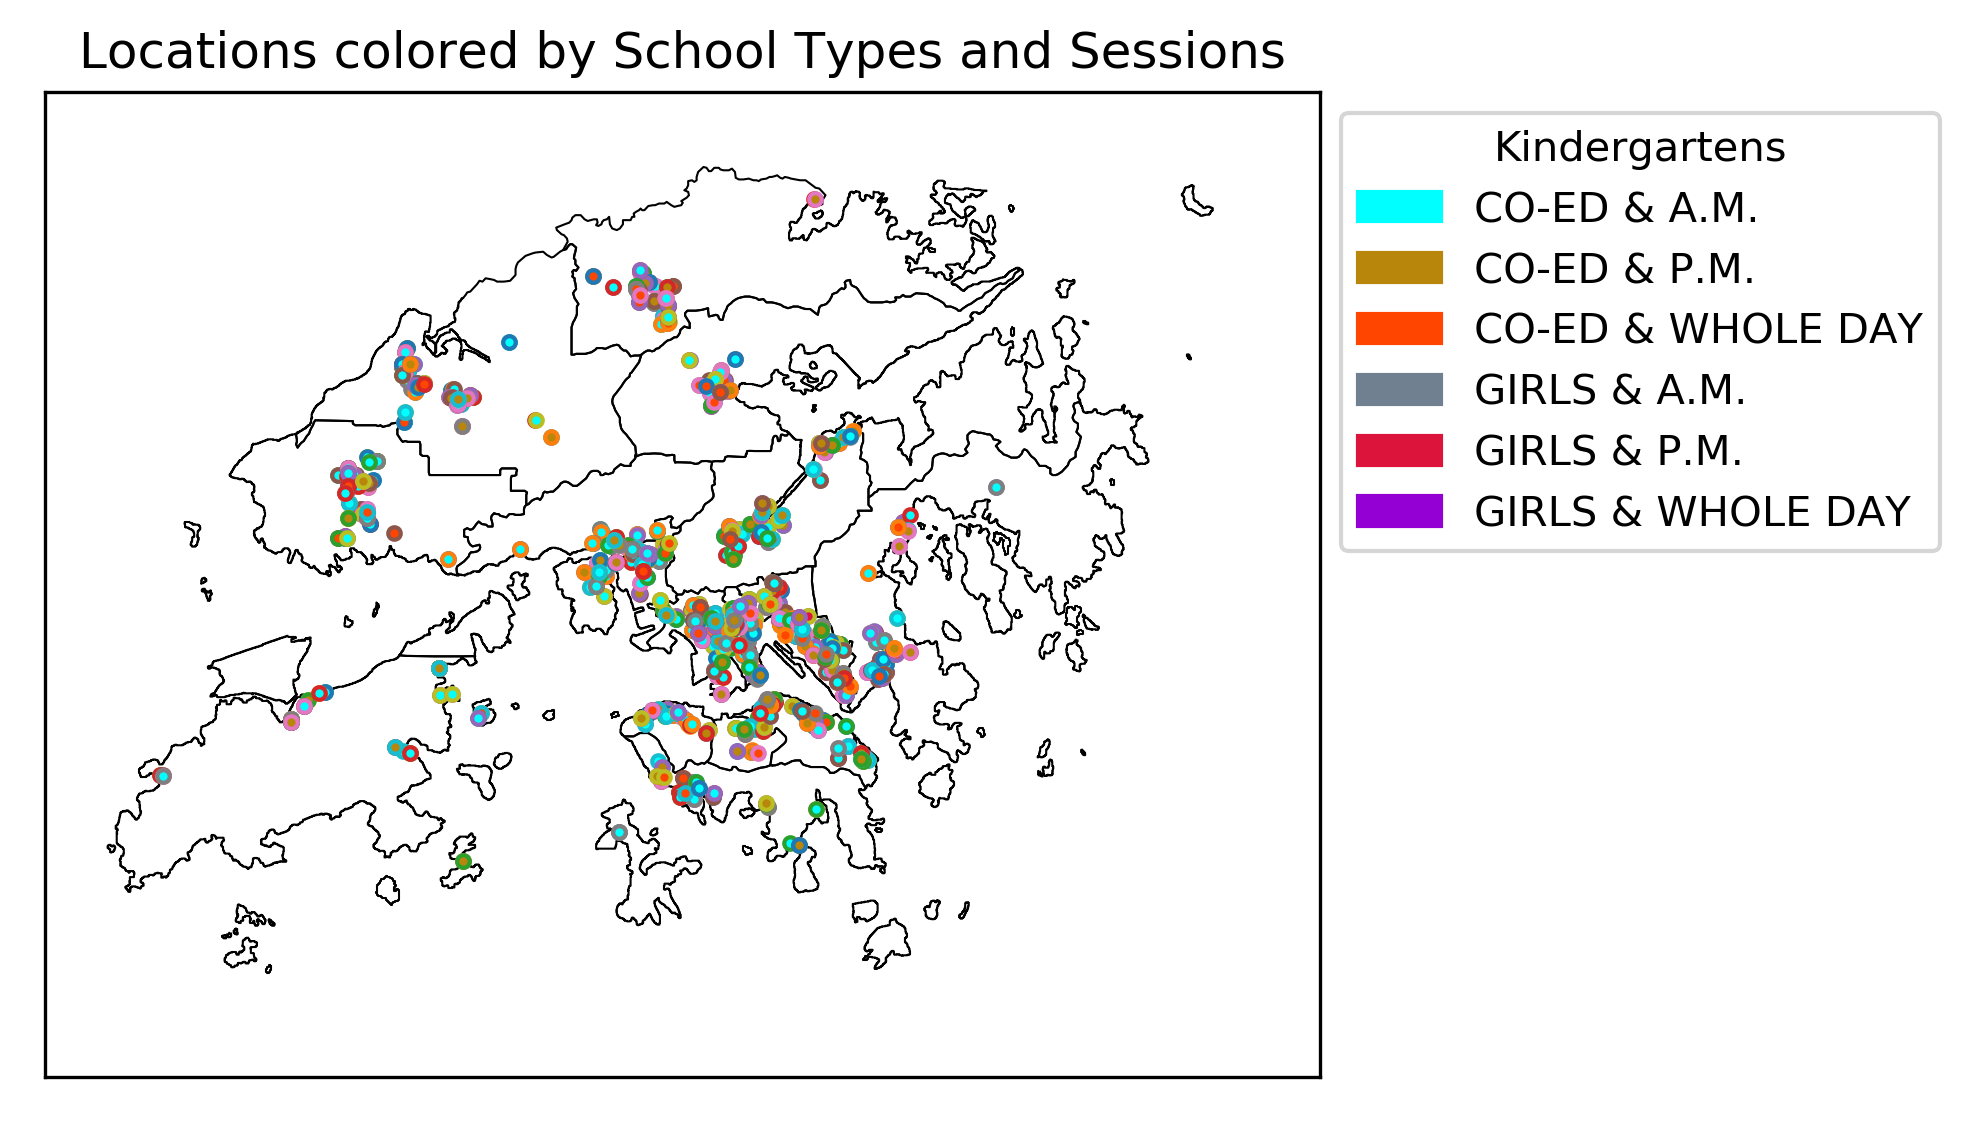

In [154]:
my_dpi=300
plt.figure(figsize=(2000/my_dpi, 1800/my_dpi), dpi=my_dpi)

#codes to produce the map
m = Basemap(llcrnrlon=113.8,llcrnrlat=22.1,urcrnrlon=114.5,urcrnrlat=22.6,
            resolution='i', projection='merc')
m.readshapefile('HKG_adm/HKG_adm1', 'hkmap')

for x, y, t, s in kindergarten[['Longitude','Latitude','Type', 'Session']].values:   
    x, y = m(x,y)
    m.plot(x, y, marker='o', markerfacecolor=pltcolor(t,s), markersize=3)

#create legend
levels = [mpatches.Patch(color='cyan', label='CO-ED & A.M.'),
          mpatches.Patch(color='darkgoldenrod', label='CO-ED & P.M.'),
          mpatches.Patch(color='orangered', label='CO-ED & WHOLE DAY'),
          mpatches.Patch(color='slategrey', label='GIRLS & A.M.'),
          mpatches.Patch(color='crimson', label='GIRLS & P.M.'),
          mpatches.Patch(color='darkviolet', label='GIRLS & WHOLE DAY')]
plt.legend(handles=levels, title='Kindergartens',bbox_to_anchor=(1.0, 1.0))

plt.title("Locations colored by School Types and Sessions")
plt.tight_layout()
plt.show()